In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
from collections import Counter
import spacy
import re
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.decomposition import TruncatedSVD
import cloudpickle

In [2]:
def get_csv_train_data(path: str):
    '''
    Read CSV file
    '''
    data = pd.read_csv(path, sep=",")
    return data

In [3]:
train_data = get_csv_train_data(os.path.join("..", "data", "train_data.csv"))

In [4]:
train_data.head()

,Unnamed: 0,S.No,USERNAME,Caption,Followers,Hashtags,Time since posted,Likes
0,18,23,amjstaffing,Shout out to #LinkedIn for the awesome lunch-n...,75,#engineer #machinelearning #automotive#automat...,4 hours,30
1,3,11,greenhousegroup,"Onze Angela en Niek hosten vandaag NextM, hét ...",828,#nextmnl#groupm #greenhousegroup #eindhoven#ef...,2 hours,90
2,0,5,bitcoinebook,"Hi #cryptomaniac friend, this is an advice for...",2372,#bitcoinsuperstar #tonylocorriere#blockchain #...,2 hours,10
3,6,15,cryptocrackhead,I officially spent the last of my tethers and ...,610,#cryptocrackhead#blockchain#cryptocurrency #cr...,2 hours,30
4,3,13,the_ios_developer,4K Ai,863,#developer #coding #programmer #javascript #pr...,2 hours,32


In [5]:
train_data.shape

(90, 8)

In [6]:
train_data.columns

Index(['Unnamed: 0', 'S.No', 'USERNAME', 'Caption', 'Followers', 'Hashtags',
       'Time since posted', 'Likes'],
      dtype='object')

In [7]:
def clean_data(data: pd.DataFrame):
    '''
    Remove unwanted columns. Remove hours from time since posted column
    '''
    data = data.copy()
    data.drop(columns=['Unnamed: 0', 'S.No', 'USERNAME', 'Caption'], inplace=True)
    data['Time since posted'] = data['Time since posted'].str.replace(r"\bhours\b", "", regex=True).astype('int')
    return data

In [8]:
train_data = clean_data(train_data)

In [9]:
train_data.head()

,Followers,Hashtags,Time since posted,Likes
0,75,#engineer #machinelearning #automotive#automat...,4,30
1,828,#nextmnl#groupm #greenhousegroup #eindhoven#ef...,2,90
2,2372,#bitcoinsuperstar #tonylocorriere#blockchain #...,2,10
3,610,#cryptocrackhead#blockchain#cryptocurrency #cr...,2,30
4,863,#developer #coding #programmer #javascript #pr...,2,32


In [10]:
train_data.dtypes

Followers             int64
Hashtags             object
Time since posted     int32
Likes                 int64
dtype: object

In [11]:
nlp = spacy.load('en_core_web_sm')
def lemmatize(s: str):
    '''
    lemmatize tags
    '''
    s = str(s)
    if len(s) > 2:
        doc = nlp(s)
        return str(doc[0].lemma_)
    else:
        return s

In [12]:
def read_acronym_list():
    acronym_list = pd.read_csv(os.path.join("..", 'utils', 'acronym_replace.csv'))
    acronym_list = acronym_list.set_index('from').T
    acronym_dict = acronym_list.to_dict(orient='records')[0]
    return acronym_dict

In [13]:
acronym_dict = read_acronym_list()
def hashtag_clean(s: str):
    s = unidecode(s)
    s = s.lower()
    s = s.replace(", ", "")
    s = s.replace(",", "")
    s = s.replace(" # ", "#")
    s = s.replace(" #", "#")
    s = s.replace("# ", "#")
    s = s.replace("\n", "")
    s = s.replace("\t", "")
    s = s.replace("\r", "")
    s = s.replace("_", "")
    s = s.replace("\xa0", "")
    s = s.replace(".", "")
    tokens = []
    for token in s.split('#')[1:]:
        if acronym_dict.get(token) is not None:
            token = acronym_dict.get(token)
        tokens.append(lemmatize(token))
    return ", ".join(list(set(tokens)))

In [14]:
def find_frequent_tags(tags: pd.Series, threshold: float=0.45):
    tokens = ", ".join(tags).split(", ")
    hashtag_freq = pd.Series(tokens).value_counts(normalize=True)*100
    freq_tags = [*hashtag_freq[hashtag_freq >= threshold].index]
    return freq_tags

In [15]:
def mark_rare_tags(s: str, freq_tags: list):
    taglist = s.split(", ")
    clean_taglist = [tag if freq_tags.count(tag) > 0 else "other_tag" for tag in taglist]
    return ", ".join(clean_taglist)

In [16]:
def clean_hashtag_column(tags: pd.Series, threshold: float=0.45):
    clean_hashtags = tags.map(hashtag_clean)
    freq_tags = find_frequent_tags(clean_hashtags)
    clean_hashtags = clean_hashtags.apply(mark_rare_tags, freq_tags=freq_tags)
    return clean_hashtags, freq_tags

In [17]:
train_data['clean_hashtags'], freq_tags = clean_hashtag_column(train_data['Hashtags'])

In [18]:
train_data['clean_hashtags']

0     machinelearne, other_tag, other_tag, other_tag...
1     other_tag, blockchain, artificialintelligence,...
2     other_tag, blockchain, crypto, other_tag, prod...
3     blockchain, bitcoin, other_tag, other_tag, oth...
4     other_tag, other_tag, other_tag, other_tag, ot...
                            ...                        
85    artificialintelligence, other_tag, other_tag, ...
86    other_tag, other_tag, other_tag, other_tag, ot...
87    deeplearne, other_tag, blockchain, artificiali...
88    other_tag, other_tag, other_tag, development, ...
89    datum, artificialintelligence, bigdata, other_...
Name: clean_hashtags, Length: 90, dtype: object

In [19]:
freq_tags

['artificialintelligence',
 'machinelearne',
 'technology',
 'blockchain',
 'startup',
 'development',
 'bigdata',
 'datascience',
 'product',
 'deeplearne',
 'design',
 'entrepreneur',
 'business',
 'iot',
 'datum',
 'crypto',
 'code',
 'cryptocurrency',
 'programming',
 'businessowner',
 'bitcoin',
 'ethereum']

In [20]:
def find_unique_tags(tags: pd.Series):
    tokens = ", ".join(tags).split(", ")
    return list(set(tokens))

In [21]:
unique_tags = find_unique_tags(train_data['clean_hashtags'])

In [22]:
unique_tags

['deeplearne',
 'blockchain',
 'datum',
 'design',
 'machinelearne',
 'bitcoin',
 'code',
 'artificialintelligence',
 'product',
 'bigdata',
 'businessowner',
 'other_tag',
 'entrepreneur',
 'datascience',
 'programming',
 'crypto',
 'cryptocurrency',
 'business',
 'startup',
 'iot',
 'technology',
 'development',
 'ethereum']

In [23]:
pd.Series(unique_tags).to_csv(os.path.join("..", 'utils', "training_data_tags.csv"), index=False)

In [24]:
def spread_hashtags(data: pd.DataFrame):
    data = data.reset_index(drop=True).copy()
    data['other_tag'] = 0
    i = 0
    for row_n in tqdm(range(len(data['clean_hashtags']))):
        row = data['clean_hashtags'][row_n]
        for tag in row.split(", "):
            if tag == "other_tag":
                data.loc[row_n, tag] += 1
            else:
                data.loc[row_n, tag] = 1
    data.fillna(0, inplace=True)
    return data

In [25]:
train_data = spread_hashtags(train_data)

100%|█████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 464.70it/s]


In [26]:
train_data

,Followers,Hashtags,Time since posted,Likes,clean_hashtags,other_tag,machinelearne,artificialintelligence,technology,blockchain,...,deeplearne,bigdata,datascience,design,entrepreneur,business,startup,iot,datum,businessowner
0,75,#engineer #machinelearning #automotive#automat...,4,30,"machinelearne, other_tag, other_tag, other_tag...",16,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,828,#nextmnl#groupm #greenhousegroup #eindhoven#ef...,2,90,"other_tag, blockchain, artificialintelligence,...",9,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2372,#bitcoinsuperstar #tonylocorriere#blockchain #...,2,10,"other_tag, blockchain, crypto, other_tag, prod...",7,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,610,#cryptocrackhead#blockchain#cryptocurrency #cr...,2,30,"blockchain, bitcoin, other_tag, other_tag, oth...",24,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,863,#developer #coding #programmer #javascript #pr...,2,32,"other_tag, other_tag, other_tag, other_tag, ot...",24,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,145,#Innovation in #Connectivity #EdgeDevices#Ener...,2,16,"artificialintelligence, other_tag, other_tag, ...",6,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,383,#businesspassion#business #toptags #entreprene...,2,50,"other_tag, other_tag, other_tag, other_tag, ot...",24,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
87,2904,#blockchaintechnology #blockchains #tech#techn...,3,28,"deeplearne, other_tag, blockchain, artificiali...",7,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
88,106,#cybersecurity #programmer #development#nerd #...,2,12,"other_tag, other_tag, other_tag, development, ...",4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
def drop_unwanted_cols(data: pd.DataFrame):
    data = data.copy()
    data.drop(columns=['Hashtags', 'clean_hashtags'], inplace=True)
    return data

In [28]:
train_data = drop_unwanted_cols(train_data)

In [29]:
train_data

,Followers,Time since posted,Likes,other_tag,machinelearne,artificialintelligence,technology,blockchain,crypto,product,...,deeplearne,bigdata,datascience,design,entrepreneur,business,startup,iot,datum,businessowner
0,75,4,30,16,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,828,2,90,9,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2372,2,10,7,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,610,2,30,24,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,863,2,32,24,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,145,2,16,6,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,383,2,50,24,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
87,2904,3,28,7,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
88,106,2,12,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
train_data.columns

Index(['Followers', 'Time since posted', 'Likes', 'other_tag', 'machinelearne',
       'artificialintelligence', 'technology', 'blockchain', 'crypto',
       'product', 'bitcoin', 'cryptocurrency', 'ethereum', 'code',
       'programming', 'development', 'deeplearne', 'bigdata', 'datascience',
       'design', 'entrepreneur', 'business', 'startup', 'iot', 'datum',
       'businessowner'],
      dtype='object')

In [31]:
# likes model

In [32]:
def prepare_train_data(data: pd.DataFrame):
    likes_data = data.drop(columns=['Time since posted']).copy()
    y = likes_data['Likes'].copy()
    x = likes_data.drop(columns=['Likes']).copy()
    return x, y

In [33]:
x_train, y_train = prepare_train_data(train_data)

In [34]:
x_train.columns

Index(['Followers', 'other_tag', 'machinelearne', 'artificialintelligence',
       'technology', 'blockchain', 'crypto', 'product', 'bitcoin',
       'cryptocurrency', 'ethereum', 'code', 'programming', 'development',
       'deeplearne', 'bigdata', 'datascience', 'design', 'entrepreneur',
       'business', 'startup', 'iot', 'datum', 'businessowner'],
      dtype='object')

In [35]:
pd.Series(x_train.columns).to_csv(os.path.join("..", 'utils', "training_features.csv"), index=False)

In [36]:
x_train.shape, y_train.shape

((90, 24), (90,))

In [37]:
pd.concat([x_train, y_train], axis= 1).to_csv(os.path.join("..", "data", "train_preprocessed.csv"), index=False)

In [38]:
# y_train = np.log(y_train)

In [39]:
def train_save_model( x_train, y_train, n_splits: int=3, model_save_path: str=os.path.join("..", 'models', "best_model.pkl")):
    param_grid = {"n_estimators": [50, 100, 200, 500],
              "max_depth": [2,4,5,7]}
    gscv = GridSearchCV(estimator=RandomForestRegressor(random_state=42), cv=n_splits, scoring="neg_root_mean_squared_error", param_grid=param_grid, verbose=1)
    gscv.fit(x_train, y_train)
    print(f"BEST PARAMS: {gscv.best_params_}")
    print(f"BEST ESTIMATOR: {gscv.best_estimator_}")
    print(f"BEST SCORE: {gscv.best_score_}")
    with open(model_save_path, "wb") as file:
        cloudpickle.dump(gscv.best_estimator_, file)
    print(f"BEST MODEL SAVED TO {model_save_path}")
    return gscv.best_estimator_

In [40]:
best_model = train_save_model(x_train=x_train, y_train=y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
BEST PARAMS: {'max_depth': 2, 'n_estimators': 50}
BEST ESTIMATOR: RandomForestRegressor(max_depth=2, n_estimators=50, random_state=42)
BEST SCORE: -69.55504875365055
BEST MODEL SAVED TO ..\models\best_model.pkl


In [41]:
prediction = best_model.predict(x_train)

In [42]:
prediction

array([ 27.40785436,  42.90335712,  54.44255262,  40.69139459,
        41.02638558,  42.24651706,  27.89148679,  38.50464171,
        46.94755272,  35.74127357, 136.05203031,  44.93282703,
        30.52341714,  36.39079956,  44.05213703,  43.79557062,
        29.91316628,  33.98803765,  48.74932391,  45.61082513,
        58.65484645,  74.24105237,  52.54230244,  38.01883721,
        29.0287432 ,  62.75809961,  27.89148679,  55.85569018,
        45.6958208 ,  32.40415047,  82.33233168,  69.55713448,
        81.73945289,  36.16619717,  54.80982925,  74.43328877,
        40.82744199,  44.05213703,  35.90963075,  56.96454425,
        27.77690198,  47.94240773,  35.41255512,  36.11032119,
        48.70994529,  29.84806308,  32.04459633,  27.89148679,
        44.66573955,  44.42118465,  35.1854891 ,  41.61110805,
        71.99632944,  40.87736235,  52.6264313 ,  57.09563076,
        43.31193818,  33.01000735,  27.53590198,  32.44173765,
        34.59828851,  31.48708441,  40.62079594,  65.97

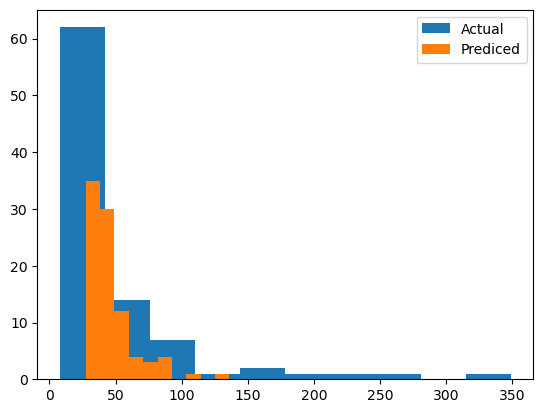

In [43]:
plt.hist(y_train, label="Actual")
plt.hist(prediction, label="Prediced")
plt.legend();

In [44]:
best_model.score(x_train, y_train) # worst r-squared

0.35344032232618827